<a href="https://colab.research.google.com/github/mirandajosee/ConvolutionalNeuralNetwork-FashionMNIST/blob/main/Clasificaci%C3%B3n_de_im%C3%A1genes_con_redes_convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrenamiento de una red neuronal convolucional utilizando ``Pytorch`` y Google Colab**
-------------------------------

En este ejemplo veremos cómo entrenar redes neuronales utilizando el framework  ``Pytorch``. Analizaremos la tarea de clasificación de imágenes, utilizando para ello dos arquitecturas diferentes: redes **feed-forward** (perceptrón multicapa) y redes **convolucionales**.

#### <u>Referencias:</u>

[Documentación de PyTorch](https://pytorch.org/)

[Tutoriales](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## **Descripción de la tarea**


### <u>Dataset</u>
El conjunto de datos a utilizar lleva el nombre de FashionMNIST, y consiste en 70000 imágenes de 28x28 píxeles, en escala de grises, con resolución de 8 bits. Cada imagen representa una prenda o accesorio de vestir, perteneciente a una de las siguientes categorías:

0.   Camiseta  (T-shirt)
1.   Pantalon  (Trouser)
2.   Pullover  (Pullover)
3.   Vestido   (Dress)
4.   Campera   (Coat)
5.   Sandalia  (Sandal)
6.   Camisa    (Shirt)
7.   Zapatilla (Sneaker)
8.   Bolso     (Bag)
9.   Bota      (Ankle boot)

En términos tabulares, el dataset contiene 28X28 columnas, cada una correspondiente a un pixel determinado, más una columna con la respectiva etiqueta.

### <u>Objetivo</u>
Entrenar un modelo que clasifique correctamente cada imagen.

### <u>Metodología</u>
Se entrenará el modelo presentándole un subconjunto de imágenes (conjunto de entrenamiento), junto con la categoría correspondiente a cada imagen (etiquetas o *labels*). Una vez entrenado el modelo, se le presentará el resto de las imágenes (conjunto de validación) y se evaluará qué porcentaje de las mismas es clasificado correctamente.

Los modelos a emplear serán redes neuronales concolucionales y de tipo perceptrón multicapa.

## **Configuración básica**

Importamos librerías, configuramos los gráficos, etc.

In [ ]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
from tqdm.notebook import tqdm              ## Barras de progreso

from random import randint 
import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos

## Configuración general
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

Observamos la versión de ``PyTorch`` disponible

In [ ]:
print(torch.__version__)

1.10.0+cu111


In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## **Cargamos el dataset**
-------------

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [ ]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Graficamos al azar algunas imágenes, con sus correspondientes etiquetas.

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [ ]:
batch_size = 64

## Creamos los data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Dimensiones de X [N, C, H, W]: ", X.shape)
    print("Dimensiones de y: ", y.shape, y.dtype)
    break

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


## **Creamos el modelo**
-------------------

Todos los modelos en ``pytorch`` se definen como subclases de una clase genérica llamada ``Module``.

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),  
            ## Aplicamos la función de activación               
            nn.ReLU(),    
            ## Reducimos la imagen con Max Pooling                  
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,                               
                padding=0
            ),    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )

        ## "Achatamos" la salida de la última capa, de 64 canales 
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 128),
            nn.Dropout(0.1), 
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Dropout(0.1), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)     
        x = self.linear_relu_stack(x)
        return x
## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
#model = MultiLayerPerceptron()
model = CNN()

## "enviamos" el modelo a la GPU o a la CPU, 
## según esté disponible
model.to(device)

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
  )
)


In [ ]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

## Definimos el optimizador
learning_rate = 1e-2 
momentum = 0.5
sgd_optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)
#
learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

## Para la red Feed-Forward elegimos este
#optimizer = sgd_optimizer

## Para la CNN funciona mejor este
optimizer = adam_optimizer

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
        

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [ ]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [ ]:
epochs = 25
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1
loss: 0.035953  [    0/60000]
loss: 0.021247  [ 6400/60000]
loss: 0.018219  [12800/60000]
loss: 0.024536  [19200/60000]
loss: 0.021716  [25600/60000]
loss: 0.021478  [32000/60000]
loss: 0.015522  [38400/60000]
loss: 0.015087  [44800/60000]
loss: 0.014720  [51200/60000]
loss: 0.008206  [57600/60000]

Train performance:
Accuracy: 79.53%, Avg loss: 0.008877
Test performance:
Accuracy: 77.98%, Avg loss: 0.009504
-------------------------------------

Época 2
loss: 0.008737  [    0/60000]
loss: 0.012555  [ 6400/60000]
loss: 0.006796  [12800/60000]
loss: 0.013191  [19200/60000]
loss: 0.012814  [25600/60000]
loss: 0.012168  [32000/60000]
loss: 0.006987  [38400/60000]
loss: 0.007801  [44800/60000]
loss: 0.009576  [51200/60000]
loss: 0.012061  [57600/60000]

Train performance:
Accuracy: 80.34%, Avg loss: 0.008333
Test performance:
Accuracy: 79.15%, Avg loss: 0.009063
-------------------------------------

Época 3
loss: 0.007234  [    0/60000]
loss: 0.011447  [ 6400/60000]
loss: 0.008865

## **Guardamos el modelo**
---------------------

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## **Cargamos un modelo guardado**
----------------------------

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).

In [ ]:
#model = MultiLayerPerceptron().to(device)
model = CNN().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## **Ovservamos las predicciones**
------------------------------

In [ ]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example,model):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

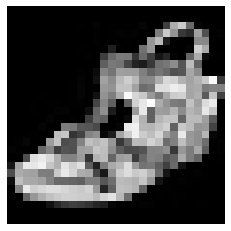

Etiqueta correcta: Sandal
----------------
Etiqueta     Probabilidad
Sandal       1.00000
Ankle Boot   0.00000
Pullover     0.00000
Bag          0.00000
T-Shirt      0.00000
Trouser      0.00000
Dress        0.00000
Coat         0.00000
Shirt        0.00000
Sneaker      0.00000


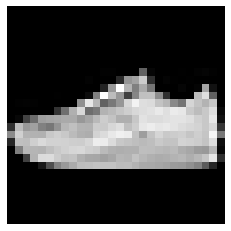

Etiqueta correcta: Sneaker
----------------
Etiqueta     Probabilidad
Sneaker      1.00000
Ankle Boot   0.00000
Pullover     0.00000
Bag          0.00000
T-Shirt      0.00000
Trouser      0.00000
Dress        0.00000
Coat         0.00000
Sandal       0.00000
Shirt        0.00000


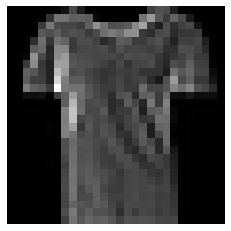

Etiqueta correcta: T-Shirt
----------------
Etiqueta     Probabilidad
T-Shirt      0.99967
Ankle Boot   0.00004
Dress        0.00004
Bag          0.00004
Trouser      0.00004
Pullover     0.00004
Sandal       0.00004
Coat         0.00004
Shirt        0.00004
Sneaker      0.00004


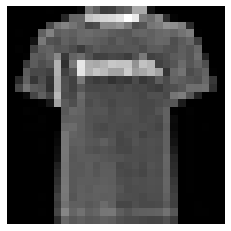

Etiqueta correcta: T-Shirt
----------------
Etiqueta     Probabilidad
T-Shirt      0.99998
Ankle Boot   0.00000
Dress        0.00000
Bag          0.00000
Trouser      0.00000
Pullover     0.00000
Sandal       0.00000
Coat         0.00000
Shirt        0.00000
Sneaker      0.00000


In [ ]:
from torch.cuda import random
example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example)

example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example)

## **Analizamos el proceso de aprendizaje**

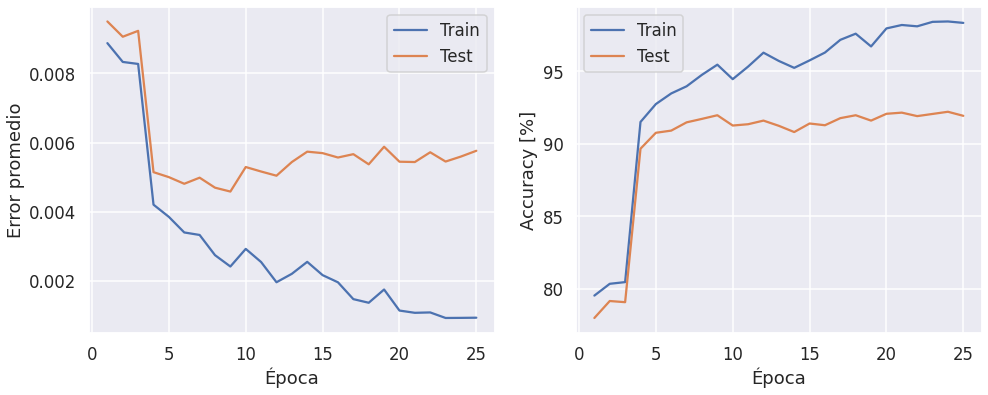

In [ ]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Época')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Train')
ax.plot(X, test_losses, label='Test')
ax.legend()

ax = axes[1]
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy [%]')
ax.plot(X, train_acc_values, label='Train')
ax.plot(X, test_acc_values, label='Test')
ax.legend()
plt.show()

#Validación

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

In [ ]:
split_idxs = np.arange(60)
split_idxs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [ ]:
np.random.shuffle(split_idxs)
split_idxs

array([27, 29, 43, 54, 38, 18, 33, 11, 59, 22, 19, 52, 31,  2, 45, 46,  1,
        6, 13,  0,  3, 24, 42, 25, 20, 10, 57,  9, 36, 15, 40, 16, 30, 47,
       12, 51, 44, 55, 50, 37, 53, 28, 32, 26, 23, 35, 17,  7,  5, 41, 56,
       34,  8, 21, 58, 39, 48, 49,  4, 14])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))
# La primera vez esto tarda un rato ya que tiene que bajar los datos de la red.

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

train_dataset_all = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# Dividimos el dataset de entrenamiento en 60 partes de 1000 muestras.
num_split = 60
size_split = len(train_dataset_all)/num_split
train_dataset_split = random_split(train_dataset_all,int(num_split-1)*[int(size_split)]+[len(train_dataset_all)-int(num_split-1)*int(size_split)])
split_idxs = np.arange(num_split)


Usando el dispositivo cuda


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class CNN(nn.Module):
    def __init__(self,n=128):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),  
            ## Aplicamos la función de activación               
            nn.ReLU(),    
            ## Reducimos la imagen con Max Pooling                  
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,                               
                padding=0
            ),    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )

        ## "Achatamos" la salida de la última capa, de 64 canales 
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, n),
            nn.Dropout(0.1), 
            nn.ReLU(),
            nn.Linear(n, 10),
            nn.Dropout(0.1), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)     
        x = self.linear_relu_stack(x)
        return x

## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
#model = MultiLayerPerceptron()
model = CNN(128)

## "enviamos" el modelo a la GPU o a la CPU, 
## según esté disponible
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
  )
)

In [ ]:
# Definimos hiperparámetros de entrenamiento
num_split = 60
learning_rate = 1e-3
batch_size = 25
num_epochs = 20
num_k = 72

# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()

# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()

# Simulamos por tramos porque google colab se desconecta antes de que concluya
# para todos los valores de n en la lista.
#sizes = [4,8,16,32,64,128,256,512,1024]
#sizes = [32,64]
sizes = [64,128,256,512,1024]
for n in sizes:
    for k in range(num_k):

        # Creamos DataLoader's de entrenamiento, validacion y testeo, eligiendo fracciones del dataset al azar
        np.random.shuffle(split_idxs)
        train_dataloader = DataLoader(train_dataset_split[split_idxs[0]], batch_size=batch_size)
        valid_dataloader = DataLoader(train_dataset_split[split_idxs[1]], batch_size=batch_size)
        test_dataloader  = DataLoader(train_dataset_split[split_idxs[2]], batch_size=batch_size)

        ## Creamos una instancia de nuestro modelo
        ## (un objeto de la clase correspondiente)
        #model = MultiLayerPerceptron()
        model = CNN(n)

        ## "enviamos" el modelo a la GPU o a la CPU, 
        ## según esté disponible
        model.to(device)
        #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

        # Entrenamos el modelo y calcualmos curvas.
        min_valid_loss = float("inf")
        for epoch in range(num_epochs):
            train_loop(train_dataloader,model,loss_fn,optimizer)
            train_loss,train_accu = test_loop(train_dataloader,model,loss_fn)
            valid_loss,valid_accu = test_loop(valid_dataloader,model,loss_fn)
            print(f"n={n} k={k} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
            df = df.append({"n":n,
                            "k":k,
                            "epoch":epoch,
                            "train_loss":train_loss,
                            "train_accu":train_accu,
                            "valid_loss":valid_loss,
                            "valid_accu":valid_accu}
                            ,ignore_index=True)
            #if valid_loss>1.1*min_valid_loss:
            #    break
            #if min_valid_loss>valid_loss:
            #    min_valid_loss=valid_loss

json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
n=128 k=38 epoch=0 train_loss=1.5976608216762542 train_accu=0.443 valid_loss=1.5991224646568298 valid_accu=0.45
n=128 k=38 epoch=1 train_loss=1.5245035529136657 train_accu=0.461 valid_loss=1.53880627900362 valid_accu=0.46
n=128 k=38 epoch=2 train_loss=1.4823011845350265 train_accu=0.472 valid_loss=1.506049247086048 valid_accu=0.468
n=128 k=38 epoch=3 train_loss=1.4718107789754868 train_accu=0.48 valid_loss=1.5229593113064765 valid_accu=0.474
n=128 k=38 epoch=4 train_loss=1.451038932800293 train_accu=0.48 valid_loss=1.5223926723003387 valid_accu=0.462
n=128 k=38 epoch=5 train_loss=1.4304222226142884 train_accu=0.482 valid_loss=1.4866379514336585 valid_accu=0.469
n=128 k=38 epoch=6 train_loss=1.431563763320446 train_accu=0.484 valid_loss=1.4912046670913697 valid_accu=0.469
n=128 k=38 epoch=7 train_loss=1.46433487534523 train_accu=0.477 valid_loss=1.518745830655098 valid_accu=0.458
n=128 k=38 epoch=8 train_loss=1.421795542

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_json(json_fname)
df

,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,0,1.096973,0.675,1.100155,0.677
1,64,0,1,0.810095,0.747,0.854326,0.721
2,64,0,2,0.724411,0.797,0.813368,0.756
3,64,0,3,0.599206,0.826,0.704792,0.788
4,64,0,4,0.572223,0.851,0.715017,0.799
...,...,...,...,...,...,...,...
7195,1024,71,15,1.856179,0.299,1.861050,0.285
7196,1024,71,16,1.852337,0.302,1.857301,0.291
7197,1024,71,17,1.858363,0.302,1.873197,0.288
7198,1024,71,18,1.849658,0.302,1.845808,0.288


In [ ]:
df1 = df.drop("k",1)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,n,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,1.096973,0.675,1.100155,0.677
1,64,1,0.810095,0.747,0.854326,0.721
2,64,2,0.724411,0.797,0.813368,0.756
3,64,3,0.599206,0.826,0.704792,0.788
4,64,4,0.572223,0.851,0.715017,0.799
...,...,...,...,...,...,...
7195,1024,15,1.856179,0.299,1.861050,0.285
7196,1024,16,1.852337,0.302,1.857301,0.291
7197,1024,17,1.858363,0.302,1.873197,0.288
7198,1024,18,1.849658,0.302,1.845808,0.288


In [ ]:
df2 = df1.pivot_table(index=["n","epoch"],aggfunc="count").reset_index()
df2

,n,epoch,train_accu,train_loss,valid_accu,valid_loss
0,64,0,72,72,72,72
1,64,1,72,72,72,72
2,64,2,72,72,72,72
3,64,3,72,72,72,72
4,64,4,72,72,72,72
...,...,...,...,...,...,...
95,1024,15,72,72,72,72
96,1024,16,72,72,72,72
97,1024,17,72,72,72,72
98,1024,18,72,72,72,72


In [ ]:
df3 = df1.pivot_table(index=["n","epoch"],aggfunc="mean").reset_index()
df3

,n,epoch,train_accu,train_loss,valid_accu,valid_loss
0,64,0,0.562972,1.393142,0.541861,1.438078
1,64,1,0.634861,1.083702,0.600861,1.173038
2,64,2,0.683986,0.946940,0.636889,1.070262
3,64,3,0.713722,0.851521,0.655958,1.005514
4,64,4,0.736528,0.779037,0.670625,0.968017
...,...,...,...,...,...,...
95,1024,15,0.252569,1.927150,0.240000,1.998113
96,1024,16,0.251167,1.931204,0.238875,2.002803
97,1024,17,0.251819,1.924767,0.239250,1.996849
98,1024,18,0.251472,1.929393,0.238597,2.001184


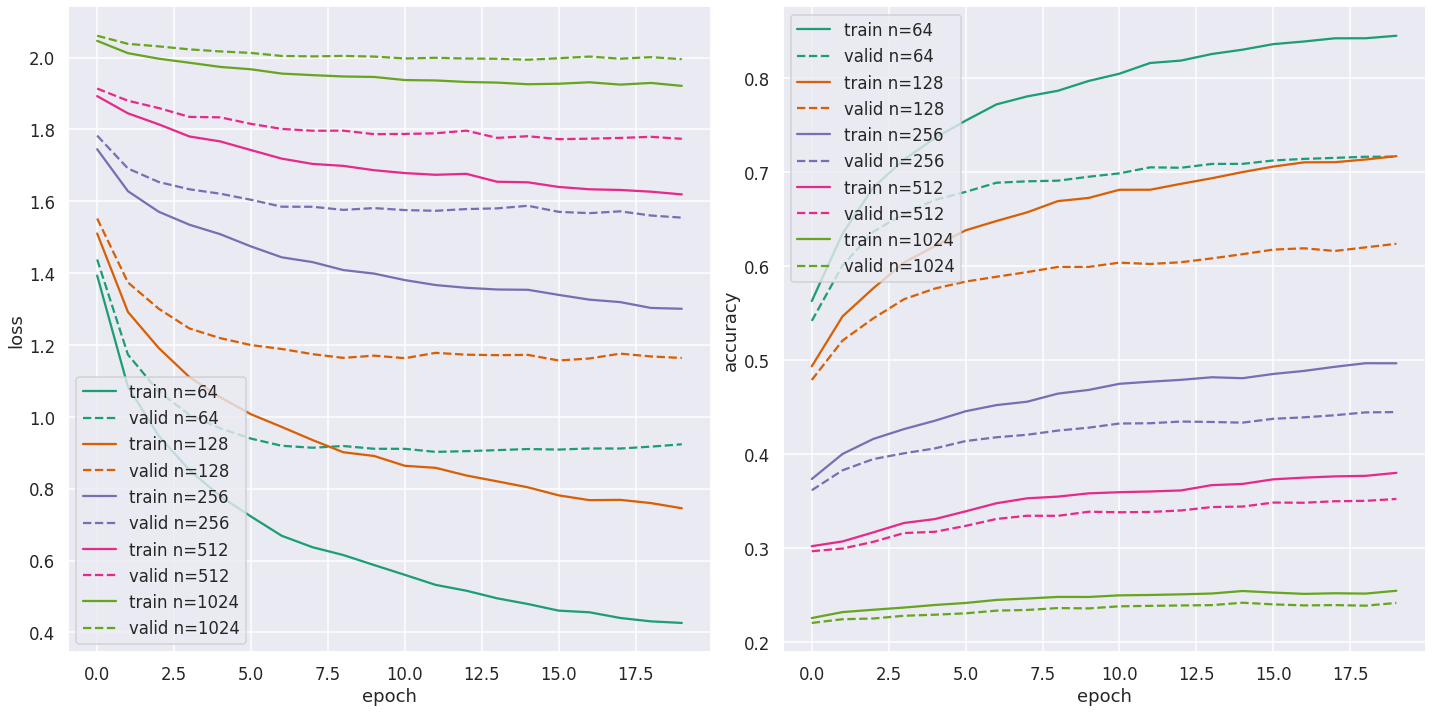

In [ ]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(20.0,10.0)
colors = cm.Dark2.colors
for color,n in zip(colors,df["n"].unique()):
    dfn = df3[df3["n"]==n]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"valid n={n}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,dfn["train_accu"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_accu"],label=f"valid n={n}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()    

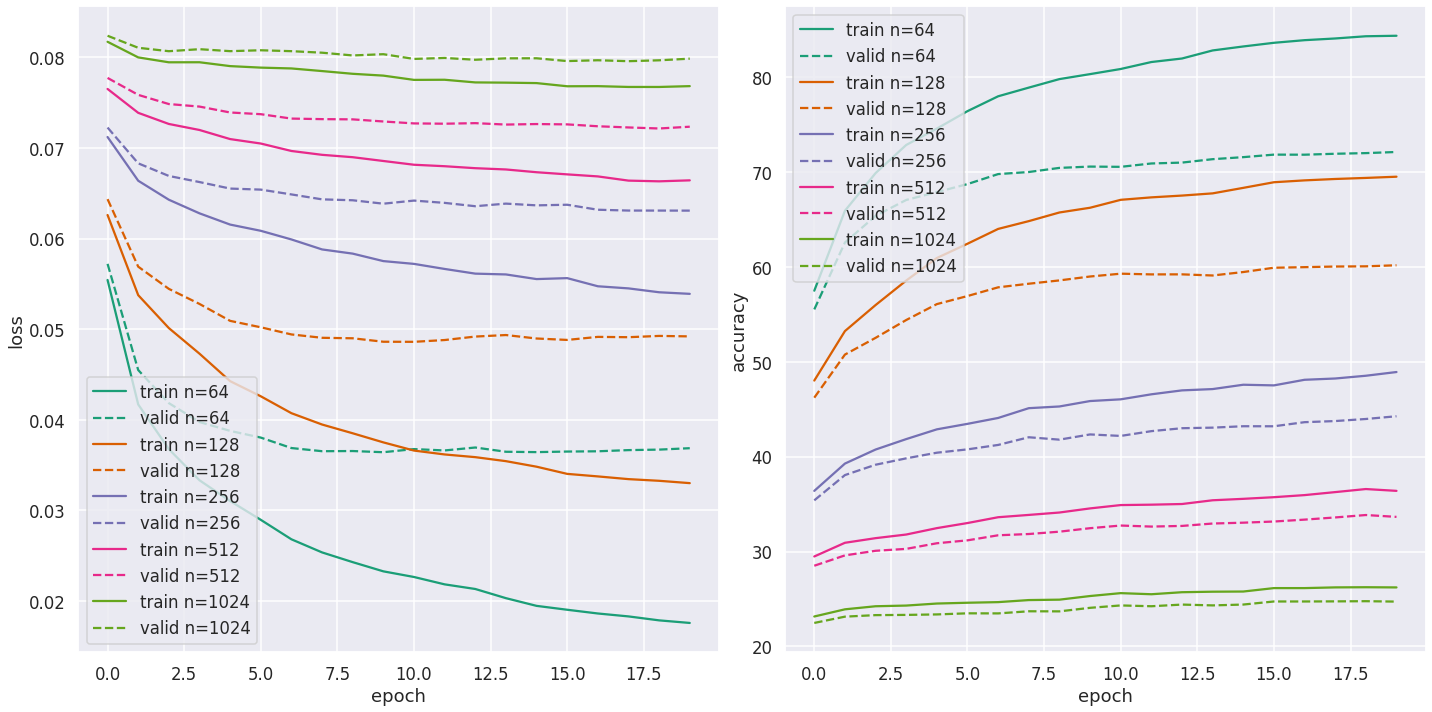

In [ ]:
#Primera vez que se ejecutó
fig,axes=plt.subplots(1,2)
fig.set_size_inches(20.0,10.0)
colors = cm.Dark2.colors
for color,n in zip(colors,df["n"].unique()):
    dfn = df3[df3["n"]==n]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"valid n={n}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,dfn["train_accu"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_accu"],label=f"valid n={n}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()    

In [ ]:
df4 = df3.pivot_table(index=["n"],
                    aggfunc={
                        "train_loss":min,
                        "valid_loss":min,
                        "train_accu":max,
                        "valid_accu":max,
                    }
                   ).reset_index()
df4

,n,train_accu,train_loss,valid_accu,valid_loss
0,64,0.845514,0.426258,0.716750,0.902401
1,128,0.717292,0.745518,0.623972,1.156783
2,256,0.496806,1.300754,0.444792,1.554440
3,512,0.380056,1.619134,0.352278,1.772884
4,1024,0.254500,1.921207,0.241736,1.993983


In [ ]:
#Primera vez que se ejecuto
df4 = df3.pivot_table(index=["n"],
                    aggfunc={
                        "train_loss":min,
                        "valid_loss":min,
                        "train_accu":max,
                        "valid_accu":max,
                    }
                   ).reset_index()
df4

,n,train_accu,train_loss,valid_accu,valid_loss
0,64,84.344444,0.017585,72.098611,0.036430
1,128,69.493056,0.033017,60.162500,0.048616
2,256,48.912500,0.053911,44.252778,0.063098
3,512,36.583333,0.066332,33.845833,0.072164
4,1024,26.237500,0.076747,24.766667,0.079593


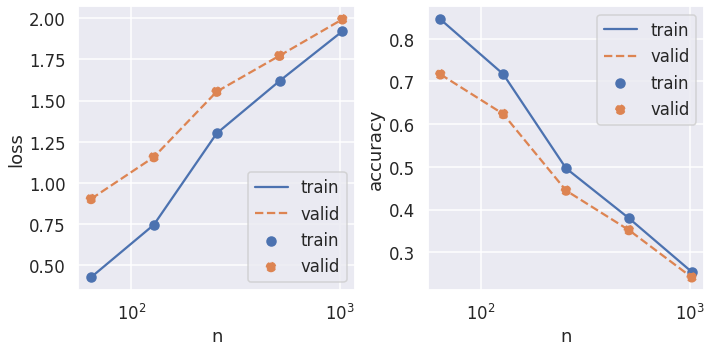

In [ ]:
x=df4["n"]
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
ax = axes[0]
ax.set_xlabel("n")
ax.set_ylabel("loss")
ax.scatter(x,df4["train_loss"],label=f"train")
ax.plot(x,df4["train_loss"],label=f"train")
ax.scatter(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax = axes[1]
ax.set_xlabel("n")
ax.set_ylabel("accuracy")
ax.scatter(x,df4["train_accu"],label=f"train")
ax.plot(x,df4["train_accu"],label=f"train")
ax.scatter(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.show()    

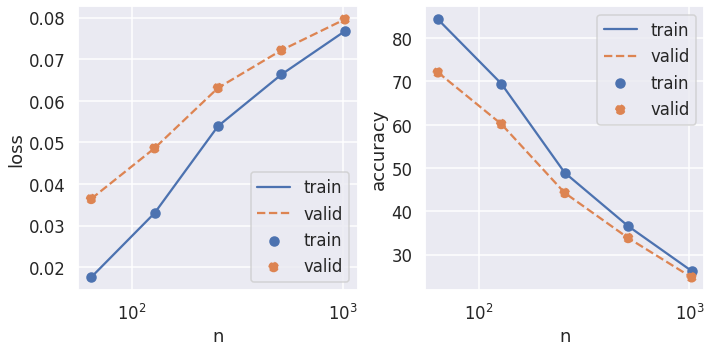

In [ ]:
#Primera vez que se ejecuto
x=df4["n"]
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
ax = axes[0]
ax.set_xlabel("n")
ax.set_ylabel("loss")
ax.scatter(x,df4["train_loss"],label=f"train")
ax.plot(x,df4["train_loss"],label=f"train")
ax.scatter(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax = axes[1]
ax.set_xlabel("n")
ax.set_ylabel("accuracy")
ax.scatter(x,df4["train_accu"],label=f"train")
ax.plot(x,df4["train_accu"],label=f"train")
ax.scatter(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.show()    

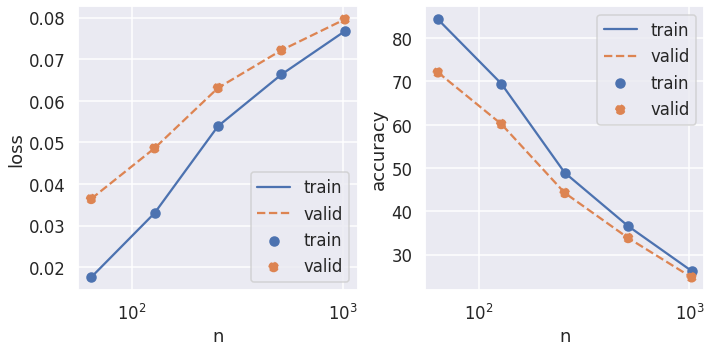

In [ ]:
#Primera vez que se ejecuto
x=df4["n"]
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
ax = axes[0]
ax.set_xlabel("n")
ax.set_ylabel("loss")
ax.scatter(x,df4["train_loss"],label=f"train")
ax.plot(x,df4["train_loss"],label=f"train")
ax.scatter(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax = axes[1]
ax.set_xlabel("n")
ax.set_ylabel("accuracy")
ax.scatter(x,df4["train_accu"],label=f"train")
ax.plot(x,df4["train_accu"],label=f"train")
ax.scatter(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.show()    

In [ ]:
%%bash --out list_json
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.json

In [ ]:
# De la variable, creamos una lista de archivos .json
list_json = list_json.split()
list_json

['simulation-results-2022-02-20-23-39-28.json']

In [ ]:
# Hacemos lista de archivos json que nos interese
json_fname_list = list_json
json_fname_list

['simulation-results-2022-02-20-23-39-28.json']

In [ ]:
# Cargamos varios archivos json como DataFrame's y los unificamos en un solo DataFrame
df_list = []
for json_fname in json_fname_list:
    df_list.append(pd.read_json(json_fname))
df = pd.concat(df_list,axis=0)
df

,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,0,0.058361,58.9,0.060177,56.7
1,64,0,1,0.042873,66.2,0.045646,64.2
2,64,0,2,0.038421,69.4,0.041929,66.6
3,64,0,3,0.035722,71.8,0.040499,66.9
4,64,0,4,0.032220,74.1,0.038019,69.1
...,...,...,...,...,...,...,...
7195,1024,71,15,0.067143,38.0,0.071465,33.9
7196,1024,71,16,0.066530,38.7,0.069954,34.6
7197,1024,71,17,0.067486,38.0,0.072398,33.2
7198,1024,71,18,0.068797,36.9,0.075808,32.8


#K-Fold

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
from sklearn.model_selection import KFold
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False


train_dataset = train_dataset_all
n=64

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=32):  
    # Calculamos cosas utiles que necesitamos
    num_samples = len(dataloader.dataset)
    # Seteamos el modelo en modo entrenamiento. Esto sirve para activar, por ejemplo, dropout, etc. durante la fase de entrenamiento.
    model.train()
    # Pasamos el modelo la GPU si está disponible.        
    model = model.to(device)    
    # Iteramos sobre lotes (batchs)
    for batch,(X,y) in enumerate(dataloader):
        # Pasamos los tensores a la GPU si está disponible.
        X = X.to(device)
        y = y.to(device)      
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso cada 100 batchs
        if batch % verbose_each*len(X) == 0:
            loss   = loss.item()
            sample = batch*len(X) # Número de batch * número de muestras en cada batch
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{sample:>5d}/{num_samples:>5d}]")            
# De manera similar, definimos la función de validación y testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_batches += 1
            num_samples += y.size(0)
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [ ]:
# Definimos hiperparámetros de entrenamiento
init_datetime = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
learning_rate = 1e-3
batch_size = 1000
max_epochs = 25
num_k = 6
# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()
# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()
# Creamos el generador de k-folds
kfold = KFold(n_splits=num_k,shuffle=False)
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.
min_valid_loss = 10000000.0
max_valid_accu = 0.0
for k,(train_ids,valid_ids) in enumerate(kfold.split(train_dataset)):
    # Creamos los dataloaders de entrenamiento y validacion
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=valid_subsampler)
    # Creamos el modelo
    model = CNN(n)
    # Creamos el optimizador
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
    # Entrenamos el modelo, calcualmos y almacenamos valores de metricas obtenidos
    min_valid_loss = float("inf")
    for epoch in range(max_epochs):
        train_loop(train_loader,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_loader,model,loss_fn)
        valid_loss,valid_accu = test_loop(valid_loader,model,loss_fn)
        print(f"k={k} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"k":k,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu,
                        "valid_loss":valid_loss,
                        "valid_accu":valid_accu}
                        ,ignore_index=True)
        if min_valid_loss > valid_loss: # or max_valid_accu < valid_accu:
            if min_valid_loss > valid_loss:
                min_valid_loss = valid_loss
            if max_valid_accu < valid_accu:
                max_valid_accu = valid_accu
            # Guardamos los parámetros del modelo.
            model_fname = "kfold-best-model-"+init_datetime+".ptm"
            print("   Saving model_fname =",model_fname,end="")
            print(" ... DONE!")
            torch.save(model.state_dict(),model_fname)
json_fname = "kfold-simulation-results-"+init_datetime+".json"
df.to_json(json_fname)
if COLAB:
    files.download(model_fname)
    files.download(json_fname)

k=0 epoch=0 train_loss=0.7639227628707885 train_accu=0.76418 valid_loss=0.7699367821216583 valid_accu=0.7584
   Saving model_fname = kfold-best-model-2022-02-21-00-46-38.ptm ... DONE!
k=0 epoch=1 train_loss=0.5968115067481995 train_accu=0.79618 valid_loss=0.6109042525291443 valid_accu=0.7907
   Saving model_fname = kfold-best-model-2022-02-21-00-46-38.ptm ... DONE!
k=0 epoch=2 train_loss=0.5505651980638504 train_accu=0.80916 valid_loss=0.5660740911960602 valid_accu=0.8028
   Saving model_fname = kfold-best-model-2022-02-21-00-46-38.ptm ... DONE!
k=0 epoch=3 train_loss=0.5068212980031968 train_accu=0.8272 valid_loss=0.529798686504364 valid_accu=0.8168
   Saving model_fname = kfold-best-model-2022-02-21-00-46-38.ptm ... DONE!
k=0 epoch=4 train_loss=0.4960354369878769 train_accu=0.826 valid_loss=0.5262154310941696 valid_accu=0.8136
   Saving model_fname = kfold-best-model-2022-02-21-00-46-38.ptm ... DONE!
k=0 epoch=5 train_loss=0.4750504630804062 train_accu=0.83802 valid_loss=0.5118758976

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%bash --out list_json
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.json

In [ ]:
list_json = list_json.split()
list_json

['kfold-simulation-results-conv-64neuronas-2022-02-21-00-46-38.json']

In [ ]:
df = pd.concat([pd.read_json(json_fname) for json_fname in list_json],ignore_index=True)
df

,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,0,0,0.763923,0.76418,0.769937,0.7584
1,0,1,0.596812,0.79618,0.610904,0.7907
2,0,2,0.550565,0.80916,0.566074,0.8028
3,0,3,0.506821,0.82720,0.529799,0.8168
4,0,4,0.496035,0.82600,0.526215,0.8136
...,...,...,...,...,...,...
145,5,20,0.139390,0.96344,0.270736,0.9223
146,5,21,0.128811,0.96518,0.270933,0.9170
147,5,22,0.116280,0.96906,0.264149,0.9215
148,5,23,0.120045,0.96880,0.272709,0.9184


In [ ]:
# Eliminamos la columna "k" que indexa los folds.
df1 = df.drop("k",1)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,epoch,train_loss,train_accu,valid_loss,valid_accu
0,0,0.763923,0.76418,0.769937,0.7584
1,1,0.596812,0.79618,0.610904,0.7907
2,2,0.550565,0.80916,0.566074,0.8028
3,3,0.506821,0.82720,0.529799,0.8168
4,4,0.496035,0.82600,0.526215,0.8136
...,...,...,...,...,...
145,20,0.139390,0.96344,0.270736,0.9223
146,21,0.128811,0.96518,0.270933,0.9170
147,22,0.116280,0.96906,0.264149,0.9215
148,23,0.120045,0.96880,0.272709,0.9184


In [ ]:
# Contamos cuantas muestras hay en cada metrica por cada epoca
df2 = df1.pivot_table(index=["epoch"],aggfunc="count").reset_index()
df2

,epoch,train_accu,train_loss,valid_accu,valid_loss
0,0,6,6,6,6
1,1,6,6,6,6
2,2,6,6,6,6
3,3,6,6,6,6
4,4,6,6,6,6
5,5,6,6,6,6
6,6,6,6,6,6
7,7,6,6,6,6
8,8,6,6,6,6
9,9,6,6,6,6


In [ ]:
# Para epoca, calculamos el promedio de cada metrica sobre muestras
df3 = df1.pivot_table(index=["epoch"],aggfunc="mean").reset_index()
df3

,epoch,train_accu,train_loss,valid_accu,valid_loss
0,0,0.796380,0.705156,0.792250,0.713227
1,1,0.836343,0.522714,0.830517,0.537982
2,2,0.847277,0.474451,0.839833,0.496464
3,3,0.862233,0.440337,0.852600,0.467873
4,4,0.867467,0.421958,0.854117,0.456882
5,5,0.872420,0.404385,0.857333,0.445181
6,6,0.892603,0.356795,0.877333,0.401039
7,7,0.897683,0.348996,0.879283,0.398042
8,8,0.900047,0.334515,0.879050,0.392524
9,9,0.905083,0.319507,0.881533,0.383717


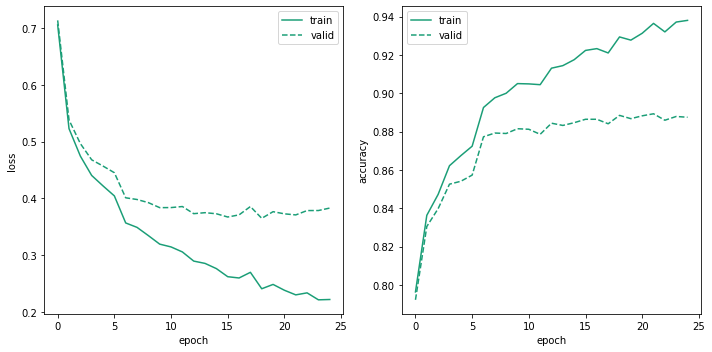

In [ ]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color in colors[:1]:
    x = df3["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,df3["train_loss"],label=f"train",color=color)
    ax.plot(x,df3["valid_loss"],label=f"valid",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,df3["train_accu"],label=f"train",color=color)
    ax.plot(x,df3["valid_accu"],label=f"valid",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
%%bash --out model_fname
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.ptm

In [ ]:
model_fname = model_fname.split()[0]

In [ ]:
model = CNN(n=64)
model.load_state_dict(torch.load(model_fname,map_location="cpu"))
model.eval()
model = model.to(device)

In [ ]:
batch_size = 1000
loss_fn = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
test_loss,test_accu = test_loop(test_loader,model,loss_fn)
print("test_loss = ",test_loss)
print("test_accu = ",test_accu)

test_loss =  0.5002877622842788
test_accu =  0.8224


In [ ]:
model_fname='kfold-best-model-conv-64neuronas-2022-02-21-00-46-38.ptm'
model = CNN(n=64)
model.load_state_dict(torch.load(model_fname,map_location="cpu"))
model.eval()
model = model.to(device)

In [ ]:
batch_size = 1000
loss_fn = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
test_loss,test_accu = test_loop(test_loader,model,loss_fn)
print("test_loss = ",test_loss)
print("test_accu = ",test_accu)

test_loss =  0.27293911576271057
test_accu =  0.9135


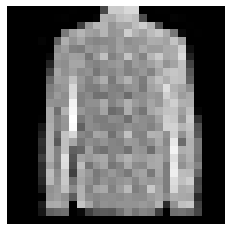

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.99061
Coat         0.00112
Ankle Boot   0.00103
Bag          0.00103
T-Shirt      0.00103
Trouser      0.00103
Dress        0.00103
Pullover     0.00103
Sandal       0.00103
Sneaker      0.00103


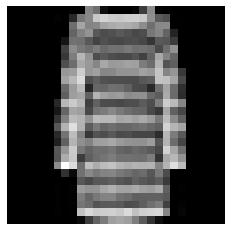

Etiqueta correcta: Dress
----------------
Etiqueta     Probabilidad
Dress        0.56741
Pullover     0.29652
Ankle Boot   0.01701
Bag          0.01701
T-Shirt      0.01701
Trouser      0.01701
Sandal       0.01701
Coat         0.01701
Shirt        0.01701
Sneaker      0.01701


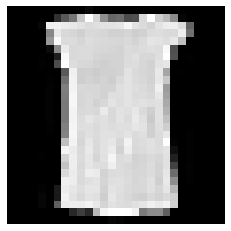

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.74997
T-Shirt      0.10959
Dress        0.06914
Ankle Boot   0.01019
Sandal       0.01019
Bag          0.01019
Pullover     0.01019
Coat         0.01019
Sneaker      0.01019
Trouser      0.01019


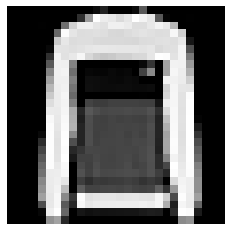

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Pullover     0.99969
Ankle Boot   0.00003
Dress        0.00003
Bag          0.00003
T-Shirt      0.00003
Trouser      0.00003
Sandal       0.00003
Coat         0.00003
Shirt        0.00003
Sneaker      0.00003


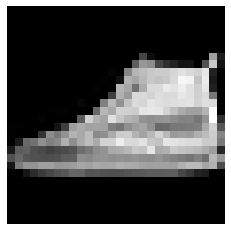

Etiqueta correcta: Sneaker
----------------
Etiqueta     Probabilidad
Sneaker      0.72606
Ankle Boot   0.20449
Bag          0.00868
Pullover     0.00868
T-Shirt      0.00868
Trouser      0.00868
Dress        0.00868
Coat         0.00868
Sandal       0.00868
Shirt        0.00868


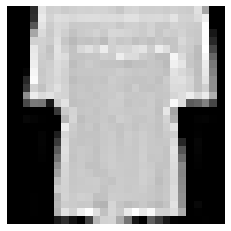

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.77212
T-Shirt      0.11060
Ankle Boot   0.01466
Bag          0.01466
Trouser      0.01466
Pullover     0.01466
Dress        0.01466
Coat         0.01466
Sandal       0.01466
Sneaker      0.01466


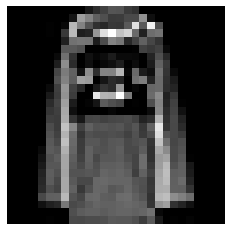

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Pullover     0.50447
Dress        0.38459
Ankle Boot   0.01387
Bag          0.01387
T-Shirt      0.01387
Trouser      0.01387
Sandal       0.01387
Coat         0.01387
Shirt        0.01387
Sneaker      0.01387


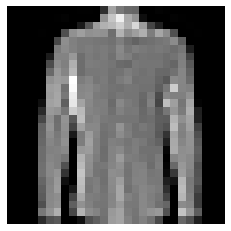

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.98692
Ankle Boot   0.00145
Pullover     0.00145
Bag          0.00145
T-Shirt      0.00145
Trouser      0.00145
Dress        0.00145
Coat         0.00145
Sandal       0.00145
Sneaker      0.00145


In [ ]:
example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(1,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example,model)

example = randint(5000,10000)
plot_img(test_data, example)
show_prediction(example,model)